In [35]:
import os
from collections.abc import Iterator

import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.base import DynSys
from neuralop import LpLoss
from neuralop.models import FNO
from neuralop.training import Trainer
from scipy.integrate import solve_ivp

from panda.utils.data_utils import safe_standardize
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../../config/plotting.yaml")

In [36]:
class KuramotoShivashinsky(DynSys):
    """Implements the 1+1D KS equation in fourier space"""

    def __init__(self, L: float, modes: int):
        self.ic = None
        super().__init__(metadata_path=None, dimension=2 * modes, parameters={})
        self.L = L
        self.modes = modes
        self.dimension = 2 * self.modes
        self.wave_nums = 2 * np.pi * np.arange(0, self.modes + 2) / self.L
        self.N = self.dimension + 2

        # precompute some quantities
        self.freq_domain = np.zeros(self.modes + 2, dtype=np.complex128)
        self.nonlinear_factor = -0.5 * 1j * self.wave_nums * self.N
        self.diffusion_ffts = self.wave_nums**2 - self.wave_nums**4

    def to_spatial(self, q: np.ndarray, N: int) -> np.ndarray:
        """Inverse FFT of the modes to get u(x) at a certain time

        :param q: array of flattened fourier coefficients (real and imag components), can have batch dimensions
        :param N: grid resolution in the spatial domain

        :returns: solution in the spatial domain
        """
        coeffs = np.zeros(q.shape[:-1] + (self.modes + 2,), dtype=complex)
        coeffs[..., 1:-1] = q[..., : self.modes] + 1j * q[..., self.modes :]
        return np.fft.irfft(coeffs, n=N)

    def rhs(self, t: float, X: np.ndarray) -> np.ndarray:
        self.freq_domain[1:-1] = X[: self.modes] + 1j * X[self.modes :]
        u = np.fft.irfft(self.freq_domain, n=self.N)
        pseudospectral_term = self.nonlinear_factor * np.fft.rfft(u * u)
        linear_term = self.diffusion_ffts * self.freq_domain

        # repackage components
        flow = (linear_term + pseudospectral_term)[1:-1]
        return np.concatenate([np.real(flow), np.imag(flow)])

In [37]:
tfinal = 100
ks = KuramotoShivashinsky(L=100, modes=64)

In [38]:
save_dir = "../../outputs/kuramoto_sivashinsky"
os.makedirs(save_dir, exist_ok=True)

n_runs = 40
parent_rng = np.random.default_rng(12)
rng_stream = parent_rng.spawn(n_runs)
traj_path = os.path.join(save_dir, f"trajectories_{n_runs}.npy")
if os.path.exists(traj_path):
    trajectories = np.load(traj_path, allow_pickle=True)
else:
    trajectories = []
    for rng in rng_stream:
        ic = 0.1 * rng.normal(size=(ks.dimension,))
        teval = np.linspace(0, tfinal, 4096)
        sol = solve_ivp(ks.rhs, (0, tfinal), ic, method="DOP853", t_eval=teval, rtol=1e-8, atol=1e-8)
        ts, freq_traj = sol.t, sol.y.T
        trajectories.append(ks.to_spatial(freq_traj, N=ks.dimension))
    np.save(traj_path, trajectories)

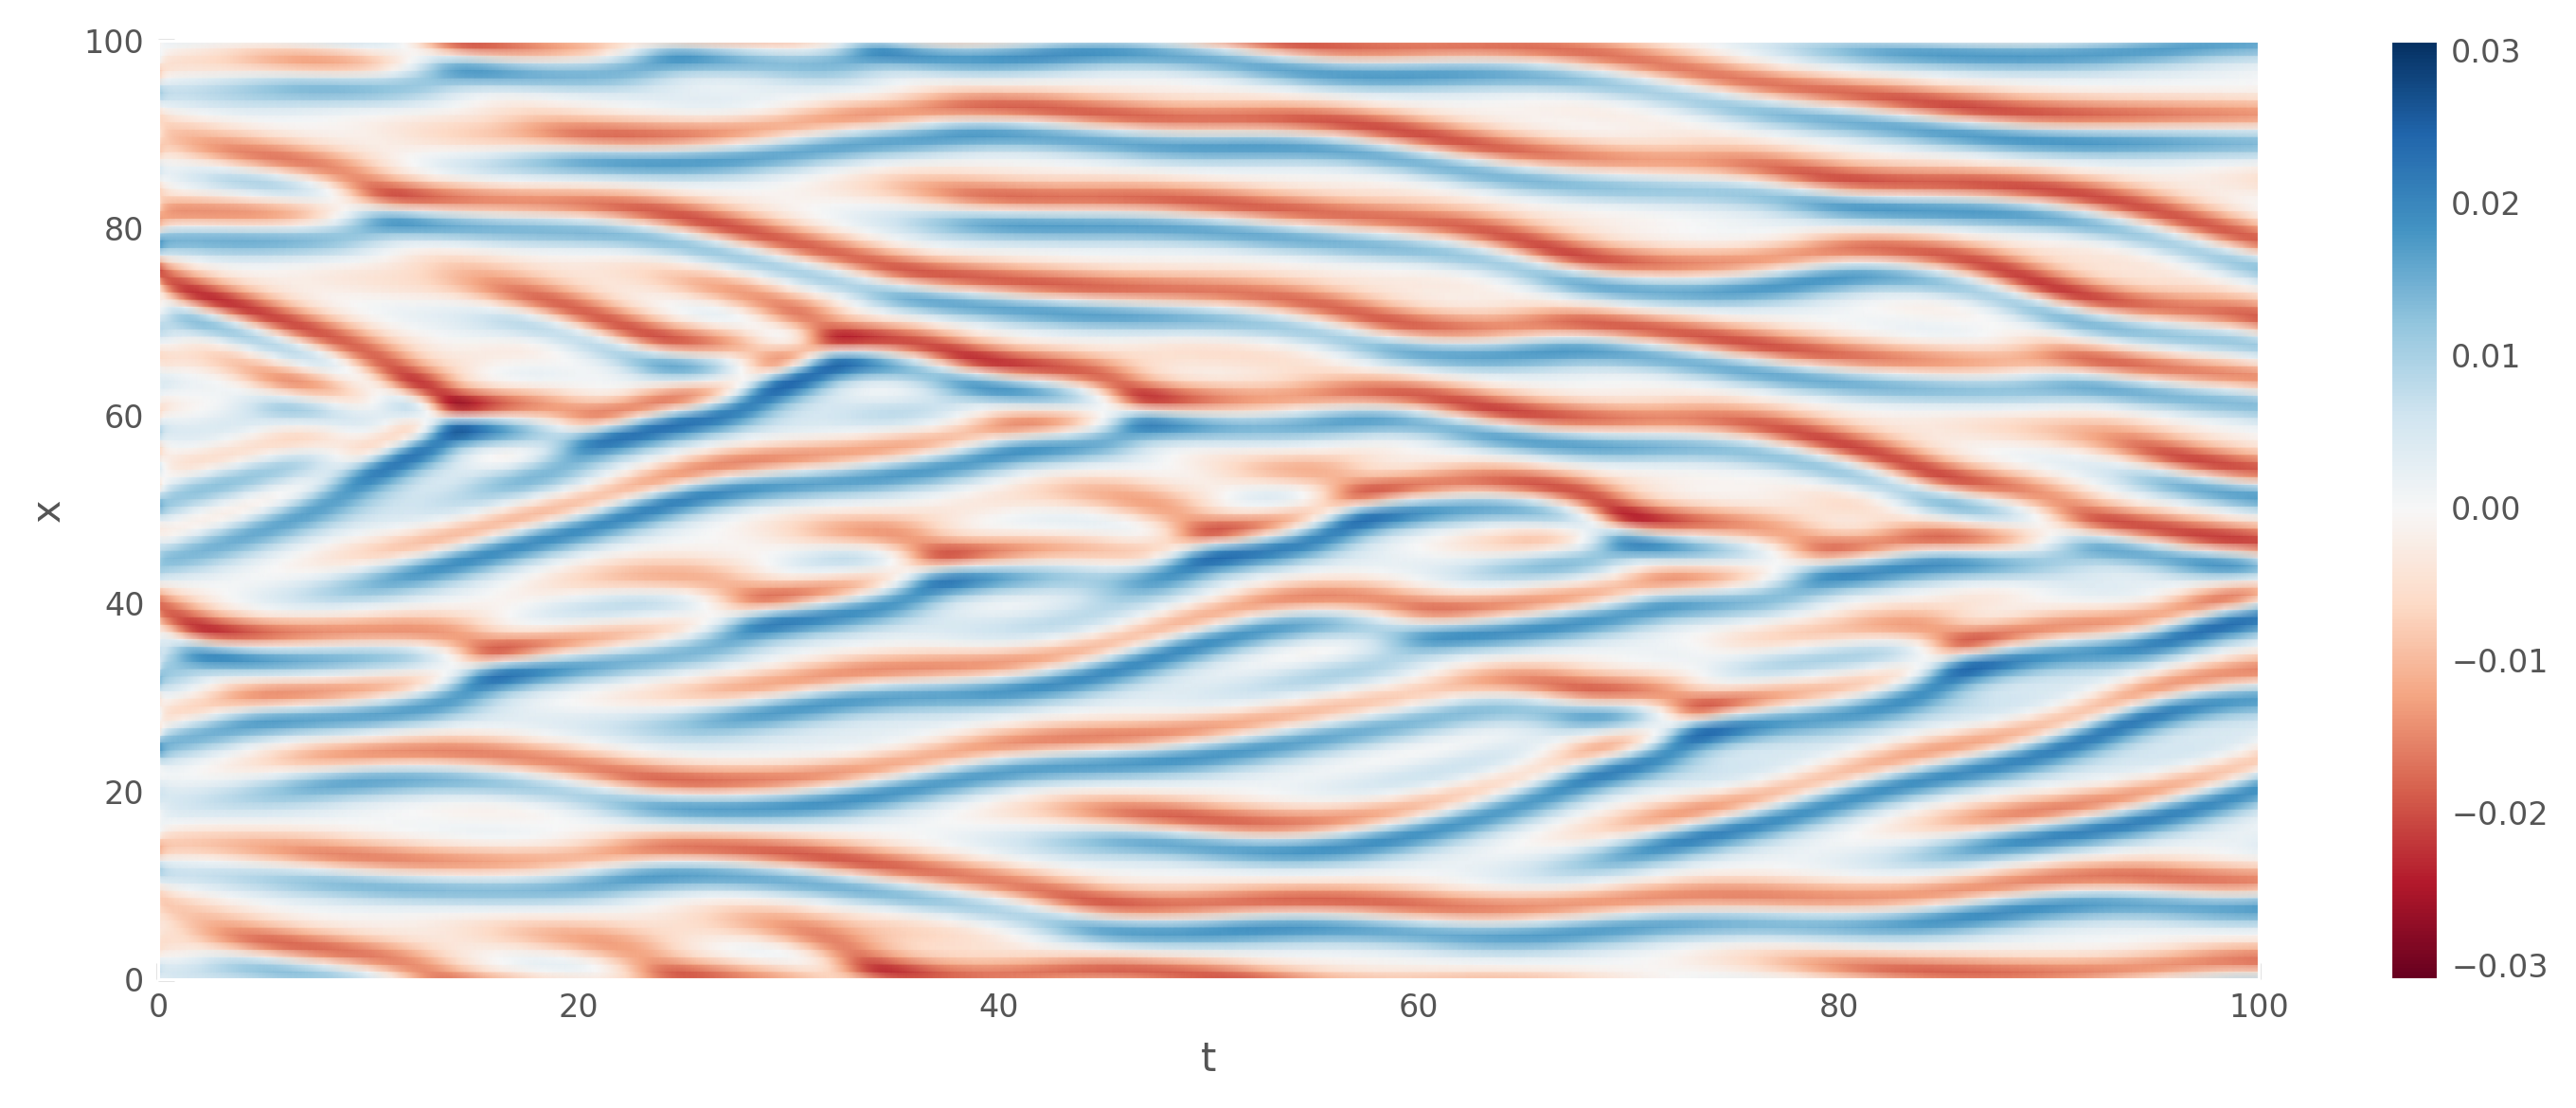

In [39]:
# plot sample trajectory
ts = np.linspace(0, tfinal, 4096)
grid = np.linspace(0, ks.L, ks.dimension)
plt.figure(figsize=(10, 4))
plt.pcolormesh(ts, grid, trajectories[0].T, cmap="RdBu", shading="gouraud")
plt.colorbar()
plt.ylabel("x")
plt.xlabel("t")
plt.show()

In [40]:
start_time = 1024
context_length = 512
prediction_length = 512
end_time = start_time + context_length + prediction_length

In [41]:
trajs = np.stack(trajectories, axis=0)[:, start_time:end_time]

In [42]:
from dataclasses import dataclass


@dataclass
class Dataset(torch.utils.data.Dataset):
    trajs: torch.Tensor  # shape: (num_trajs, T, N)
    context_length: int = 1

    def __len__(self) -> int:
        return self.trajs.shape[0] * (self.trajs.shape[1] - self.context_length)

    def __getitem__(self, idx: int) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        traj_idx = idx // (self.trajs.shape[1] - self.context_length)
        i = idx % (self.trajs.shape[1] - self.context_length)
        x = self.trajs[traj_idx, i : i + self.context_length]
        y = self.trajs[traj_idx, i + self.context_length]
        if y.ndim == 1:
            y = y[np.newaxis, :]
        if x.ndim == 1:
            x = x[np.newaxis, :]
        return {
            "x": torch.from_numpy(x).float(),
            "y": torch.from_numpy(y).float(),
        }


device_rank = 1
device = f"cuda:{device_rank}"

stand_trajs = safe_standardize(trajs, axis=1, context=trajs[:, :context_length])
context_window = stand_trajs[:, :context_length]
prediction_window = stand_trajs[:, context_length:]

num_epochs = 1000
batch_size = 512

# preprocess training context
lookback = 1
train_dataset = Dataset(context_window, context_length=lookback)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    Dataset(prediction_window, context_length=lookback), batch_size=batch_size, num_workers=0, pin_memory=True
)

operator = FNO(n_modes=(256,), hidden_channels=128, n_layers=5, in_channels=lookback, out_channels=1).to(device)
trainer = Trainer(model=operator, n_epochs=num_epochs, verbose=True, device=device)
optimizer = torch.optim.AdamW(operator.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataset) * num_epochs)
loss_fn = LpLoss(d=1)

trainer.train(
    train_loader=train_loader,
    test_loaders={"eval": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    training_loss=loss_fn,
    save_every=1000,
    save_dir="./ks_ckpt",
    save_best="eval_l2",
)

Training on 20440 samples
Testing on [20440] samples         on resolutions ['eval'].
Raw outputs of shape torch.Size([512, 1, 128])


/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1786: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/neuralop/training/trainer.py:536: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[0] time=0.72, avg_loss=0.2570, train_err=131.3521
Eval: eval_l2=0.1186
[Rank 0]: saved training state to ./ks_ckpt
[1] time=0.73, avg_loss=0.0338, train_err=17.2928


Eval: eval_l2=0.0762
[Rank 0]: saved training state to ./ks_ckpt
[2] time=0.74, avg_loss=0.0285, train_err=14.5745
Eval: eval_l2=0.0615
[Rank 0]: saved training state to ./ks_ckpt
[3] time=0.73, avg_loss=0.0277, train_err=14.1507
Eval: eval_l2=0.0687
[4] time=0.72, avg_loss=0.0197, train_err=10.0706
Eval: eval_l2=0.0846
[5] time=0.74, avg_loss=0.0195, train_err=9.9623
Eval: eval_l2=0.0637
[6] time=0.74, avg_loss=0.0213, train_err=10.8885
Eval: eval_l2=0.0545
[Rank 0]: saved training state to ./ks_ckpt
[7] time=0.73, avg_loss=0.0205, train_err=10.4946
Eval: eval_l2=0.0610
[8] time=0.73, avg_loss=0.0211, train_err=10.7952
Eval: eval_l2=0.0572
[9] time=0.73, avg_loss=0.0145, train_err=7.4152
Eval: eval_l2=0.0558
[10] time=0.74, avg_loss=0.0188, train_err=9.6209
Eval: eval_l2=0.0648
[11] time=0.74, avg_loss=0.0171, train_err=8.7267
Eval: eval_l2=0.0673
[12] time=0.96, avg_loss=0.0151, train_err=7.7270
Eval: eval_l2=0.0501
[Rank 0]: saved training state to ./ks_ckpt
[13] time=0.73, avg_loss

{'train_err': 6.025207799673081,
 'avg_loss': 0.01179101330660094,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.7319078310392797,
 'eval_l2': tensor(0.0454, device='cuda:1')}

In [43]:
def plot_forecast(
    ts: np.ndarray,
    grid: np.ndarray,
    trajectory: np.ndarray,
    predictions: np.ndarray,
    run_name: str = "",
    context_length: int = 512,
    save_path: str | None = None,
    v_abs: float | None = None,
    prediction_horizon: int = 128,
    cmap_name: str = "RdBu",
    title_kwargs: dict = {},
    draw_prediction_horizon_line: bool = True,
    figsize: tuple[int, int] = (9, 9),
    show_cbar: bool = True,
    show_ticks: bool = True,
    show_axes_labels: bool = True,
    show_context: bool = True,
):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=figsize)

    vmin = min(trajectory.min(), predictions.min())
    vmax = max(trajectory.max(), predictions.max())
    vabs = v_abs or max(abs(vmin), abs(vmax))

    if not show_context:
        ts = ts[context_length:]
    for i, (ax, data, label) in enumerate(
        zip(
            axes,
            [trajectory, predictions, predictions - trajectory],
            [
                "Ground Truth",
                f"Predictions ({run_name})" if run_name else "Predictions",
                "Error",
            ],
        )
    ):
        if not show_context:
            data = data[context_length:]
        im = ax.pcolormesh(ts, grid, data.T, cmap=cmap_name, shading="gouraud", vmin=-vabs, vmax=vabs)
        if show_ticks:
            ax.set_ylabel("x")
        else:
            ax.set_yticks([])

        ax.set_title(label, **title_kwargs)
        if show_cbar:
            fig.colorbar(im, ax=ax)
        # draw black vertical line at middle of plot (x axis middle)

        if show_context:
            ax.axvline(ts[context_length], color="black", linewidth=1)

        if i == 2 and draw_prediction_horizon_line:
            # draw a black dotted vertical line at the end of 128 pred length window
            start = context_length if show_context else 0
            ax.axvline(
                ts[start + prediction_horizon],
                color="gray",
                linestyle="--",
                linewidth=1,
            )
    if show_ticks:
        axes[-1].set_xlabel("t")
    else:
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

    if show_axes_labels:
        axes[-1].set_xlabel("Time", fontweight="bold")
        for ax in axes:
            ax.set_ylabel("x", fontweight="bold")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    return vabs


In [44]:
def rollout(ic: torch.Tensor, num_steps: int, model: torch.nn.Module) -> torch.Tensor:
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        pred = model(state)
        traj.append(pred)
        state = torch.cat([state[:, :-1, :], pred], dim=1)
    return torch.cat(traj, dim=1)

In [45]:
# load best model
WORK_DIR = os.path.expandvars("$WORK")
operator.load_state_dict(
    # torch.load(f"{WORK_DIR}/FNO_KS/best_model_state_dict.pt", map_location=device, weights_only=False)
    torch.load("ks_ckpt/best_model_state_dict.pt", map_location=device, weights_only=False)
)
operator.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-4): 5 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([128, 128, 129]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-4): 5 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-4): 5 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-4): 5 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 1, ker

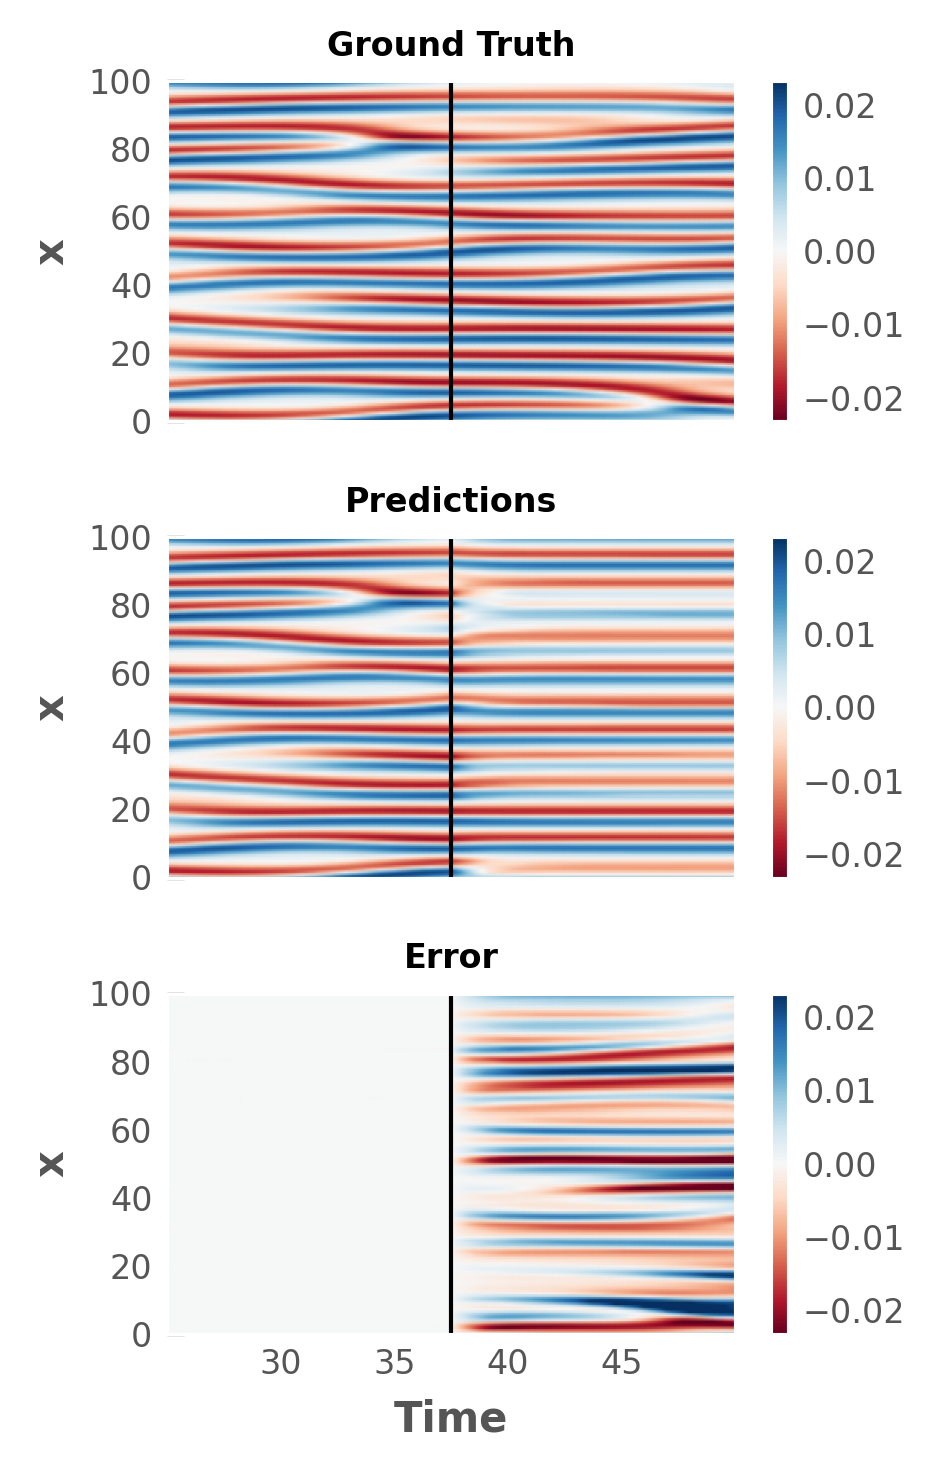

In [47]:
# visualize sample prediction
sample = 10
prediction = (
    rollout(
        torch.from_numpy(context_window[sample, -lookback:]).float().to(device).unsqueeze(0),
        model=operator,
        num_steps=prediction_length,
    )
    .squeeze()[lookback:]
    .cpu()
    .detach()
    .numpy()
)  # shape: (pred_length, N)

prediction_traj = np.concatenate([context_window[sample], prediction], axis=0)
prediction_traj = safe_standardize(prediction_traj, axis=0, context=trajs[sample, :context_length], denormalize=True)

_ = plot_forecast(
    ts[start_time:end_time],
    grid,
    trajs[sample, :end_time],
    prediction_traj,
    context_length=context_length,
    cmap_name="RdBu",
    show_context=True,
    figsize=(3.2, 5),
    title_kwargs={"fontweight": "bold", "fontsize": 8},
    draw_prediction_horizon_line=False,
)
